In [2]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02
r2 = 1

eq = Dt(u(t, x)) - Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * Dxx(u(t,x))) ~ 0.0

bcs = [u(0, x) ~ cospi(x)-exp(-4*π*π*abs2(x)),
    u(t, -1.0) ~ u(t, 1.0),
    Dx(u(t, -1.0)) ~ Dx(u(t, 1.0))]

domains = [t ∈ Interval(0.0, 1.0),
    x ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem(eq, bcs, domains, [t,x], [u(t,x)])

In [9]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = BetaRandomSampler(1000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (500,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.7681307792663574 -0.597476601600647; -0.3206896483898163 -1.8685961961746216; … ; -1.9617767333984375 -1.9500426054000854; -1.499742865562439 0.04439353942871094], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.32677674293518066 0.16994799673557281 … -0.1653909683227539 -0.209084153175354; 0.16555511951446533 -0.37161552906036377 … -0.20920968055725098 -0.3313658535480499; … ; -0.34702029824256897 -0.20887364447116852 … 0.6210490465164185 0.3510076105594635; 0.20030461251735687 -0.7134135961532593 … -0.13579660654067993 -0.5855113863945007], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.04080371931195259 0.6500579118728638 … 0.40928468108177185 -0.44607630372047424; -0.1848781406879425 -0.552057147026062 … 0.23718802630901337 0.297392874956131; … ; 0.5717203617095947 0.0665668323636055 … 0.36528950929641724 0.49616551399230957; -0.47279641032218933 0.32183489203453064 … -0

In [10]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 973531.1726805607


Loss: 16.319250486853893


Loss: 10.309925482395037


Loss: 5.596304742876694


Loss: 4.850317768894852


Loss: 4.389620907734436


Loss: 3.5038227463707425


Loss: 2.533873708299117


Loss: 1.663166565240326


Loss: 1.073371252704681


Loss: 0.7183983583800828
219.485494 seconds (46.42 M allocations: 265.891 GiB, 5.69% gc time)


u: ComponentVector{Float64}(layer_1 = (weight = [-0.28517447525750683 -0.18084480405603037; -0.730582153645685 0.9242903744936926; … ; -1.9214266887476539 0.15494205649103243; -2.3163721444777647 0.5976455511287251], bias = [-2.3250039648431113; -5.998285700018114; … ; -6.03567425205228; -5.0367652955757585;;]), layer_2 = (weight = [-8.257464710447854 -5.2707398220133115 … -5.697871297935851 -3.6782272901973214; 3.6398415633122743 -0.7015013388388799 … -0.3631005432055934 -1.9191157916642665; … ; 1.3094235374893444 1.1738946369950782 … 2.081189506256606 2.1747148373202605; 1.1480732173088848 5.372058394783671 … 5.816138778232214 4.884189612879031], bias = [5.127254569011955; 3.9280058224888896; … ; -3.408874831979602; -3.9537712065817767;;]), layer_3 = (weight = [0.6278769122503514 -4.5889111067404516 … 1.2613894991052417 -0.40928681317243987; 0.9813295533395154 -1.1775801637153447 … -0.8338629517409546 1.4824937939457583; … ; -0.5554378948008747 1.56643079355292 … 1.2438875425498102 -

In [ ]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

Loss: 0.9740737223705016


Loss: 0.4862176581949854


Loss: 0.19253445033525907


Loss: 0.08943497392037432


Loss: 0.049881656794276745


Loss: 0.03545189895718339


Loss: 0.02671976275743342


Loss: 0.02028903903298171


Loss: 0.016398437313886936


Loss: 0.013226520091661736


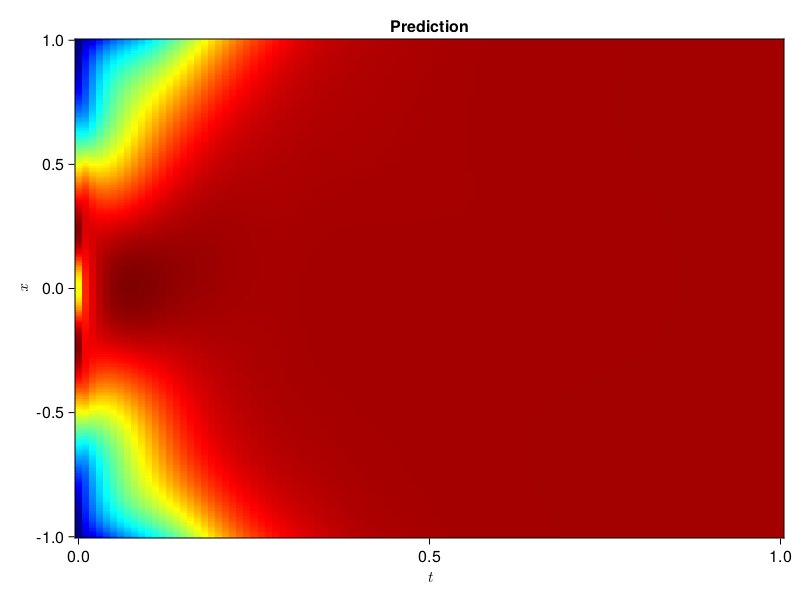

Loss: 0.010779575553922468


Loss: 3.896696244898342


Loss: 0.051544923949651905


Loss: 0.00965252585038546


Loss: 0.0052829323925921495


Loss: 0.003488853085957198


Loss: 0.0027207963227459018


Loss: 0.002255489542150203


In [12]:
for α in [0.6, 0.8, 1.0] 
    i = 0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end